# **Load Data**

In [1]:
#Packages
library(dplyr)
library(reshape2)
library(ggplot2)
library(tidyverse)
library(pryr)
library(rpart)
library(fastDummies)
library(GGally)
library(ggcorrplot)
library(stringr)
library(xgboost)
library(caret)
library(SHAPforxgboost)
library(igraph)
list.files(path = "../input")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.1.1     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'pryr':
  method      from
  print.bytes Rcpp


Attaching package: ‘pryr’


The following objects are masked from ‘package:purrr’:

    compose, partial


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loading required package: lattice


Attaching package: ‘caret’


The following 

[1] "mockinsurancedatasetrandgen"

In [2]:
#main dataset
dat <- read.csv("../input/mockinsurancedatasetrandgen/xdat.csv",header=TRUE)

In [3]:
#Check data loaded correctly
dim(dat)
head(dat)
tail(dat)
dat %>%
  summarise_all(funs(sum(is.na(.)))) # count NAs in each column

[1] 100000     27

,ID,POLICY_QUARTER,SEQUENCE_NUMBER,MPC,MODEL_AGE,BASE_PRICE,HORSEPOWER,DRIVERS,EXCLUDED_DRIVERS,DRIVER_AGE,⋯,DEV_04,DEV_05,DEV_06,DEV_07,DEV_08,DEV_09,DEV_10,DEV_11,DEV_12,DEV_13
,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,200012,0,PIP,11,22290,475,2,0,64,⋯,0,0,0,0,0,0,0,0,0,0
2,2,200012,2,CMP,20,38445,201,3,1,31,⋯,0,0,0,0,0,0,0,0,0,0
3,3,200012,3,PD,13,46021,183,1,2,82,⋯,0,0,0,0,0,0,0,0,0,0
4,4,200012,1,PD,7,22660,493,2,0,47,⋯,0,0,0,0,0,0,0,0,0,0
5,5,200012,1,PIP,6,22916,247,2,0,76,⋯,0,0,0,0,0,0,0,0,0,0
6,6,200012,0,UM,14,44539,53,1,2,31,⋯,0,0,0,0,0,0,0,0,0,0


,ID,POLICY_QUARTER,SEQUENCE_NUMBER,MPC,MODEL_AGE,BASE_PRICE,HORSEPOWER,DRIVERS,EXCLUDED_DRIVERS,DRIVER_AGE,⋯,DEV_04,DEV_05,DEV_06,DEV_07,DEV_08,DEV_09,DEV_10,DEV_11,DEV_12,DEV_13
,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
99995,99995,200312,0,PIP,18,40068,156,1,2,29,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
99996,99996,200312,1,OTHR_2,16,33918,281,2,1,48,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
99997,99997,200312,1,BI,9,21224,328,2,1,42,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
99998,99998,200312,3,BI,17,43653,148,3,0,94,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
99999,99999,200312,0,PD,16,15241,434,2,0,94,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
100000,100000,200312,0,PD,17,27764,360,1,0,27,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


ID,POLICY_QUARTER,SEQUENCE_NUMBER,MPC,MODEL_AGE,BASE_PRICE,HORSEPOWER,DRIVERS,EXCLUDED_DRIVERS,DRIVER_AGE,⋯,DEV_04,DEV_05,DEV_06,DEV_07,DEV_08,DEV_09,DEV_10,DEV_11,DEV_12,DEV_13
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,⋯,26524,37026,46776,57537,66714,76496,83861,91182,95103,99287


# **Data Cleaning/Normalization**

In [4]:
#Grab important columns
DEV_01_col_num <- which(colnames(dat)=="DEV_01")
DEV_13_col_num <- which(colnames(dat)=="DEV_13")
loss_cols <- dat[DEV_01_col_num:DEV_13_col_num]

#Check highest/ lowest loss value
max_losses <- max(loss_cols, na.rm = TRUE)
print(max_losses)

[1] 100000


In [5]:
#One hot encoding for categorical data
dummies <- dat[-c(DEV_01_col_num:DEV_13_col_num)]
dummies <-
  dummy_cols(
    dummies,
    select_columns = c("MPC", "GENDER","HOMEOWNER","CREDIT_SCORE"),
    remove_first_dummy = TRUE,
    remove_most_frequent_dummy = FALSE,
    ignore_na = FALSE,
    split = NULL,
    remove_selected_columns = TRUE
    )

dummies[is.na(dummies)] <- 0
dummies_cols <- ncol(dummies)

In [6]:
#Normalize non-loss values
i=2
while (i <= dummies_cols){
  col_min <- min(dummies[i])
  assign(paste("min", i,sep = "_"), col_min)
  col_range <- diff(range(dummies[i]))
  assign(paste("range", i,sep = "_"), col_range)
  dummies[i] <- apply(dummies[i], MARGIN = 2, FUN = function(X) (X - col_min)/col_range)
  i = i+1
}

dat_dummies <- cbind(dummies,loss_cols)
                      
#Redetermine important column numbers
DEV_01_col_num <- which(colnames(dat_dummies)=="DEV_01")
DEV_13_col_num <- which(colnames(dat_dummies)=="DEV_13")
      
#Normalize loss values                      
i <- DEV_13_col_num
while (i >= DEV_01_col_num) {
dat_dummies <- dat_dummies[c(1:i)]
drop_na_rows_and_cols <- dat_dummies %>% drop_na()
dat_losses <- apply(drop_na_rows_and_cols[DEV_01_col_num:i], MARGIN = 2, FUN = function(X) X/max_losses)
other_vars <- drop_na_rows_and_cols[1:(DEV_01_col_num-1)]
dat_normalized <- cbind(other_vars,dat_losses) 
assign(paste0("dat_DEV_", str_pad((i+1-DEV_01_col_num), 2, pad = "0")),dat_normalized)
i = i-1
}

In [7]:
#Lots of vars instantiated now, so quick check again
ls()
head(dat_DEV_04)

[1] "auth"                      "col_min"                  
  [3] "col_range"                 "dat"                      
  [5] "dat_DEV_01"                "dat_DEV_02"               
  [7] "dat_DEV_03"                "dat_DEV_04"               
  [9] "dat_DEV_05"                "dat_DEV_06"               
 [11] "dat_DEV_07"                "dat_DEV_08"               
 [13] "dat_DEV_09"                "dat_DEV_10"               
 [15] "dat_DEV_11"                "dat_DEV_12"               
 [17] "dat_DEV_13"                "dat_dummies"              
 [19] "dat_losses"                "dat_normalized"           
 [21] "DEV_01_col_num"            "DEV_13_col_num"           
 [23] "drop_na_rows_and_cols"     "dummies"                  
 [25] "dummies_cols"              "get_user_secret"          
 [27] "GET_USER_SECRET_ENDPOINT"  "i"                        
 [29] "KAGGLE_BASE_URL"           "KAGGLE_IAP_TOKEN"         
 [31] "KAGGLE_USER_SECRETS_TOKEN" "loss_cols"                
 [33] "max_losses"                "min_10"                   
 [35] "min_11"                    "min_12"                   
 [37] "min_13"                    "min_14"                   
 [39] "min_15"                    "min_16"                   
 [41] "min_17"                    "min_18"                   
 [43] "min_19"                    "min_2"                    
 [45] "min_20"                    "min_21"                   
 [47] "min_22"                    "min_23"                   
 [49] "min_24"                    "min_25"                   
 [51] "min_26"                    "min_27"                   
 [53] "min_28"                    "min_29"                   
 [55] "min_3"                     "min_30"                   
 [57] "min_31"                    "min_32"                   
 [59] "min_33"                    "min_34"                   
 [61] "min_4"                     "min_5"                    
 [63] "min_6"                     "min_7"                    
 [65] "min_8"                     "min_9"                    
 [67] "other_vars"                "range_10"                 
 [69] "range_11"                  "range_12"                 
 [71] "range_13"                  "range_14"                 
 [73] "range_15"                  "range_16"                 
 [75] "range_17"                  "range_18"                 
 [77] "range_19"                  "range_2"                  
 [79] "range_20"                  "range_21"                 
 [81] "range_22"                  "range_23"                 
 [83] "range_24"                  "range_25"                 
 [85] "range_26"                  "range_27"                 
 [87] "range_28"                  "range_29"                 
 [89] "range_3"                   "range_30"                 
 [91] "range_31"                  "range_32"                 
 [93] "range_33"                  "range_34"                 
 [95] "range_4"                   "range_5"                  
 [97] "range_6"                   "range_7"                  
 [99] "range_8"                   "range_9"                  
[101] "TokenBigQueryKernel"

,ID,POLICY_QUARTER,SEQUENCE_NUMBER,MODEL_AGE,BASE_PRICE,HORSEPOWER,DRIVERS,EXCLUDED_DRIVERS,DRIVER_AGE,WRITTEN_PREMIUM,⋯,CREDIT_SCORE_601-650M,CREDIT_SCORE_651-700M,CREDIT_SCORE_701-750H,CREDIT_SCORE_751-800H,CREDIT_SCORE_801-850H,CREDIT_SCORE_NA,DEV_01,DEV_02,DEV_03,DEV_04
,<int>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",⋯,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,0.0000000,0.5263158,0.3842308,0.944444444,0.5,0.0,0.6075949,0.06572066,⋯,0,0,0,0,0,0,0,0,0,0
2,2,0,0.6666667,1.0000000,0.7432387,0.335555556,1.0,0.5,0.1898734,0.17790178,⋯,0,0,0,0,0,0,0,0,0,0
3,3,0,1.0000000,0.6315789,0.9115980,0.295555556,0.0,1.0,0.8354430,0.85020850,⋯,0,0,0,0,0,0,0,0,0,0
4,4,0,0.3333333,0.3157895,0.3924532,0.984444444,0.5,0.0,0.3924051,0.76584766,⋯,0,0,0,0,0,0,0,0,0,0
5,5,0,0.3333333,0.2631579,0.3981422,0.437777778,0.5,0.0,0.7594937,0.07262073,⋯,0,0,0,0,0,0,0,0,0,0
6,6,0,0.0000000,0.6842105,0.8786640,0.006666667,0.0,1.0,0.1898734,0.57443574,⋯,0,0,0,0,0,0,0,0,0,0


In [8]:
# choosing training and test samples

#for now we'll be predicting the 4th development period, although we could easily use a 
#multistep timeseries/individual claims chain ladder approach to predict development for all policy quarters

set.seed(42)
fold <- sample(1:5, nrow(dat_DEV_04), replace = TRUE)
dat_DEV_04$fold <- fold
train <- dat_DEV_04[dat_DEV_04$fold != 5,]    # 80%
test <- dat_DEV_04[dat_DEV_04$fold == 5,]    # 20%

train_y = train$DEV_04
train_x <- subset(train, select = -c(DEV_04,fold))

test_y = test$DEV_04
test_x = subset(test, select = -c(DEV_04,fold))

xgb_train = xgb.DMatrix(label = train_y, data = as.matrix(train_x))
xgb_test = xgb.DMatrix(label = test_y, data = as.matrix(test_x))

In [9]:
max(dat_DEV_04$DEV_04)
min(dat_DEV_04$DEV_04)

min_losses <- min(loss_cols, na.rm = TRUE)
print(min_losses)

[1] 1

[1] 0

[1] 0


# **Train ML Model (XGBoost)**

[07:59:30] WARNING: amalgamation/../src/learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[1]	train-mae:0.070938	train-rmse:0.075381	val-mae:0.071375	val-rmse:0.075870 
Multiple eval metrics are present. Will use val_rmse for early stopping.
Will train until val_rmse hasn't improved in 50 rounds.

[11]	train-mae:0.017399	train-rmse:2.492420	val-mae:0.000672	val-rmse:0.008194 
[21]	train-mae:0.017356	train-rmse:2.575108	val-mae:0.000648	val-rmse:0.008172 
[31]	train-mae:0.016976	train-rmse:2.551804	val-mae:0.000634	val-rmse:0.008143 
[41]	train-mae:0.016704	train-rmse:2.522575	val-mae:0.000622	val-rmse:0.008133 
[51]	train-mae:0.016592	train-rmse:2.508324	val-mae:0.000612	val-rmse:0.008129 
[61]	train-mae:0.016568	train-rmse:2.506996	val-m

   user  system elapsed 
 21.488   0.018  11.116 

##### xgb.Booster
raw: 1.9 Kb 
call:
  xgb.train(params = params, data = xgb_train, nrounds = 2000, 
    watchlist = list(train = xgb_train, val = xgb_test), print_every_n = 10, 
    early_stopping_rounds = 50, max_depth = 5, eval_metric = "mae", 
    eval_metric = "rmse")
params (as set within xgb.train):
  booster = "gblinear", objective = "reg:tweedie", max_depth = "5", eval_metric = "mae", eval_metric = "rmse", validate_parameters = "TRUE"
xgb.attributes:
  best_iteration, best_msg, best_ntreelimit, best_score, niter
callbacks:
  cb.print.evaluation(period = print_every_n)
  cb.evaluation.log()
  cb.early.stop(stopping_rounds = early_stopping_rounds, maximize = maximize, 
    verbose = verbose)
# of features: 37 
niter: 237
best_iteration : 187 
best_ntreelimit : 187 
best_score : 0.008111 
best_msg : [187]	train-mae:0.016932	train-rmse:2.560275	val-mae:0.000586	val-rmse:0.008111 
nfeatures : 37 
evaluation_log:
    iter train_mae train_rmse  val_mae val_rmse
       1  0.070938   0

[1] 2.634103

[1] 6.90791

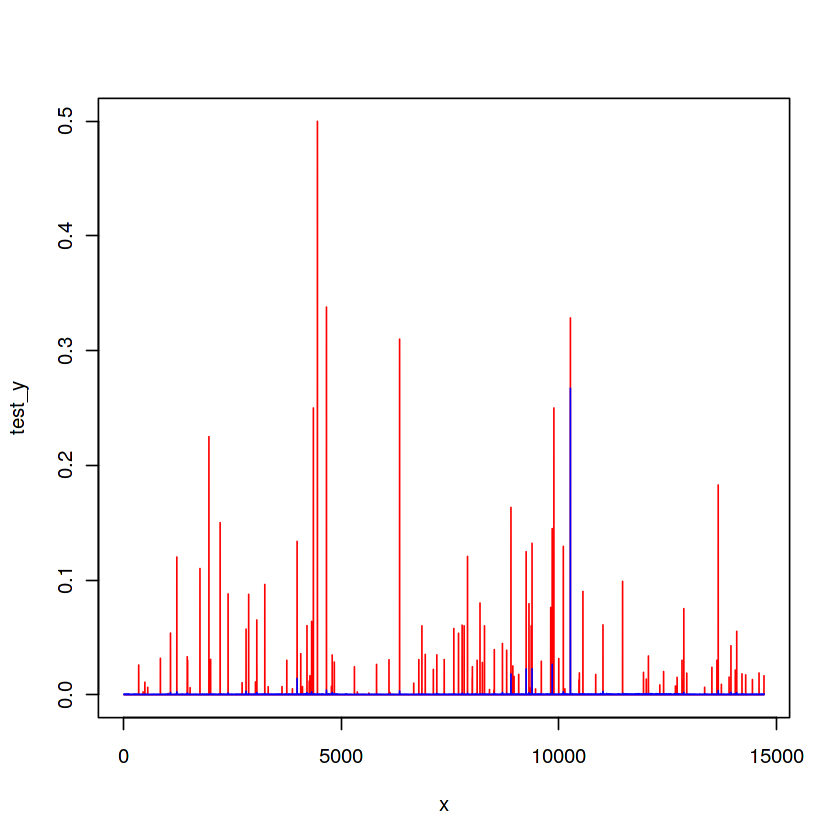

In [10]:
#"Train" model using just basic guesses for hyper parameters. The main purpose here is instantiation, we will tune in next nb cell.

{t1 <- proc.time()
params <- list(booster = "gblinear",
               objective = "reg:tweedie")

xgbc <-  xgb.train (params = params,
                    data = xgb_train,
                    max_depth = 5,
                    nrounds =2000,
                    print_every_n = 10,
                    eval_metric = "mae",
                    eval_metric = "rmse",
                    early_stopping_rounds = 50,
                    watchlist = list(train= xgb_train, val= xgb_test))
(proc.time()-t1)}

print(xgbc)

## make predictions and compare results
pred_y = predict(xgbc, xgb_test)

mse = mean((test_y - pred_y)^2)
mae = caret::MAE(test_y, pred_y)
rmse = caret::RMSE(test_y, pred_y)
cat("MSE: ", mse, "MAE: ", mae, " RMSE: ", rmse)

x = 1:length(test_y)
plot(x, test_y, col = "red", type = "l")
lines(x, pred_y, col = "blue", type = "l")
legend(x = 1, y = 38,  legend = c("original test_y", "predicted test_y"),
col = c("red", "blue"), box.lty = 1, cex = 0.8, lty = c(1, 1))
sum(pred_y)
sum(test_y)

In [15]:
## RANDOM SEARCH HYPERPARAMETER OPTIMIZATION. COMMENTED OUT AFTER RUNNING TO DETERMINE HYPERPARAMETERS.

# Take start time to measure time of random search algorithm
start.time <- Sys.time()

# Create empty lists
lowest_error_list = list()
parameters_list = list()

# Create 1,000 rows with random hyperparameters
set.seed(20)
for (iter in 1:100){

  param <- list(booster = "gbtree",
                objective = "reg:tweedie",
                max_depth = sample(3:10, 1),
                eta = runif(1, .01, .3),
                subsample = runif(1, .7, 1),
                colsample_bytree = runif(1, .6, 1),
                min_child_weight = sample(0:10, 1)
  )
  parameters <- as.data.frame(param)
  parameters_list[[iter]] <- parameters
}

# Create object that contains all randomly created hyperparameters
parameters_df = do.call(rbind, parameters_list)

# Use randomly created parameters to create 1,000 XGBoost-models
for (row in 1:nrow(parameters_df)){
  set.seed(20)
  mdcv <- xgb.train(data=xgb_train,
                    booster = "gbtree",
                    objective = "reg:tweedie",
                    max_depth = parameters_df$max_depth[row],
                    eta = parameters_df$eta[row],
                    subsample = parameters_df$subsample[row],
                    colsample_bytree = parameters_df$colsample_bytree[row],
                    min_child_weight = parameters_df$min_child_weight[row],
                    nrounds= 25,
                    eval_metric = "rmse",
                    #early_stopping_rounds= 50,
                    print_every_n = 5,
                    watchlist = list(train= xgb_train, val= xgb_test)
  )
  lowest_error <- as.data.frame(1 - min(mdcv$evaluation_log$val_rmse))
  lowest_error_list[[row]] <- lowest_error
}

# Create object that contains all accuracy's
lowest_error_df = do.call(rbind, lowest_error_list)

# Bind columns of accuracy values and random hyperparameter values
randomsearch = cbind(lowest_error_df, parameters_df)

# Quickly display highest accuracy
max(randomsearch$`1 - min(mdcv$evaluation_log$val_error)`)

# Stop time and calculate difference
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

write_csv(randomsearch, "data/randomsearch.csv")
# Prepare table
randomsearch <- as.data.frame(randomsearch) %>%
  rename(val_acc = `1 - min(mdcv$evaluation_log$val_error)`) %>%
  arrange(-val_acc)

[1]	train-rmse:0.287513	train-mae:0.287430	val-rmse:0.287397	val-mae:0.287358 
Multiple eval metrics are present. Will use val_mae for early stopping.
Will train until val_mae hasn't improved in 5 rounds.

[2]	train-rmse:0.165422	train-mae:0.165468	val-rmse:0.165372	val-mae:0.165345 
[3]	train-rmse:0.095271	train-mae:0.095212	val-rmse:0.095232	val-mae:0.095193 
[4]	train-rmse:0.055029	train-mae:0.054858	val-rmse:0.055021	val-mae:0.054880 
[5]	train-rmse:0.031930	train-mae:0.031640	val-rmse:0.031976	val-mae:0.031666 
[6]	train-rmse:0.018917	train-mae:0.018310	val-rmse:0.019095	val-mae:0.018365 
[7]	train-rmse:0.011687	train-mae:0.010613	val-rmse:0.012024	val-mae:0.010681 
[8]	train-rmse:0.008099	train-mae:0.006220	val-rmse:0.008652	val-mae:0.006297 
[9]	train-rmse:0.006246	train-mae:0.003643	val-rmse:0.006971	val-mae:0.003724 
[10]	train-rmse:0.005379	train-mae:0.002158	val-rmse:0.006178	val-mae:0.002239 
[11]	train-rmse:0.004955	train-mae:0.001300	val-rmse:0.005806	val-mae:0.001383 
[1

[1] 2.634103

[1] 6.90791

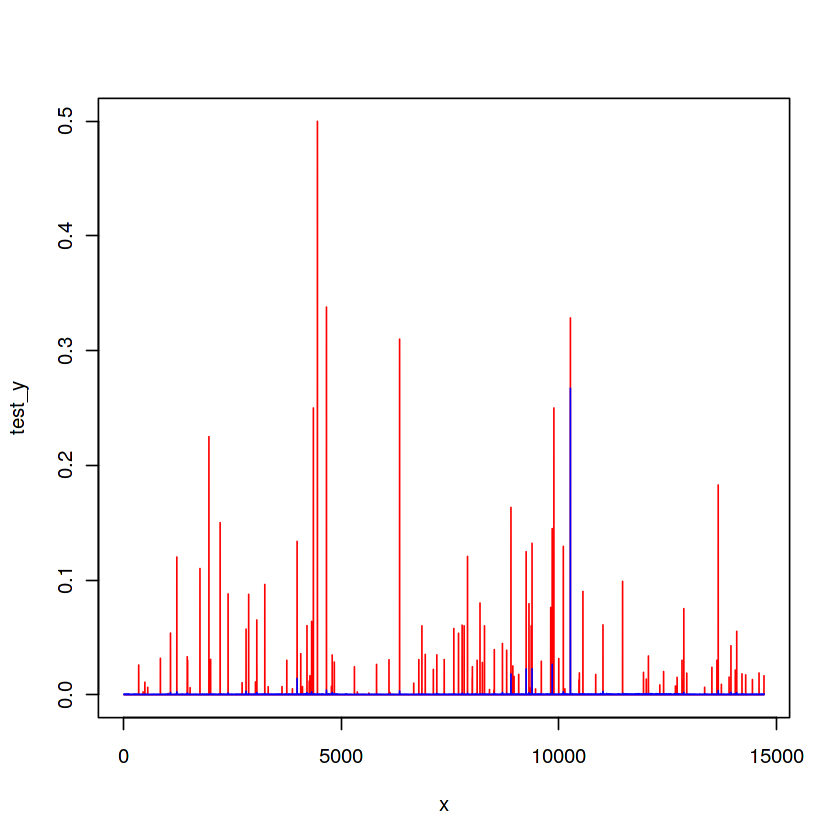

In [17]:
# Now run XGBoost again, with tuned hyperparameters
params <- list( booster = 'gbtree',
                objective = 'reg:tweedie',
                max_depth = 9, #randomsearch[1,]$max_depth,
                eta = 0.2766045, #randomsearch[1,]$eta,
                subsample = 0.7184733, #randomsearch[1,]$subsample,
                colsample_bytree = 0.6570611, #randomsearch[1,]$colsample_bytree,
                min_child_weight = 6) #randomsearch[1,]$min_child_weight)

xgb_tuned = xgb.train(params = params,
                       data = xgb_train,
                       nrounds = 20,
                       print_every_n = 1,
                       eval_metric = "rmse",
                       eval_metric = "mae",
                       early_stopping_rounds = 5,
                       watchlist = list(train= xgb_train, val= xgb_test))
 
print(xgb_tuned)

## make predictions
## make predictions and compare results
pred_y = predict(xgbc, xgb_test)

mse = mean((test_y - pred_y)^2)
mae = caret::MAE(test_y, pred_y)
rmse = caret::RMSE(test_y, pred_y)
cat("MSE: ", mse, "MAE: ", mae, " RMSE: ", rmse)

x = 1:length(test_y)
plot(x, test_y, col = "red", type = "l")
lines(x, pred_y, col = "blue", type = "l")
legend(x = 1, y = 38,  legend = c("original test_y", "predicted test_y"),
col = c("red", "blue"), box.lty = 1, cex = 0.8, lty = c(1, 1))
sum(pred_y)
sum(test_y)

# **Interpretable AI**
Experimenting with SHAP
 

In [ ]:
# To prepare the long-format data:
shap_long <- shap.prep(xgb_model = xgb_tuned, X_train = train_x)

In [ ]:
# **SHAP summary plot**
shap.plot.summary(shap_long)

In [ ]:
# sometimes for a preview, you want to plot less data to make it faster using `dilute`
shap.plot.summary(shap_long, x_bound  = 1.2, dilute = 10)

In [ ]:
# Alternatives options to make the same plot:
shap.plot.summary.wrap1(xgb_tuned, X = train_x)

In [ ]:
# notice: this step is slow since it calculates all the combinations of features.
# It may take over 5 minutes on a personal laptop.
shap_int <- shap.prep.interaction(xgb_mod = xgb_tuned, X_train = train_x)

In [ ]:
# it is the same as:
shap_int <- predict(xgb_tuned, train_x, predinteraction = TRUE)